✅ Saved predicted_grades_percent_scaled.csv


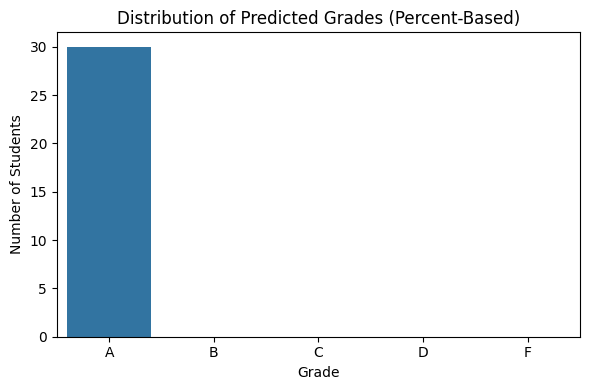

In [7]:
# 📦 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor

# 📥 Load student-level feature dataset
df = pd.read_csv("../data/processed/student_features_with_scores.csv")  # Adjust path if needed

# 🎯 Separate features and target
X = df.drop(columns=["Student_Id", "Total Score"])
y = df["Total Score"]

# 🧼 Impute missing values
imputer = SimpleImputer(strategy="mean")
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# ✂️ Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 🤖 Train XGBoost Model
xgb_model = XGBRegressor(random_state=42, verbosity=0)
xgb_model.fit(X_train, y_train)

# 📈 Predict Scores
y_pred_scores = xgb_model.predict(X_test)

# 🧩 Step: Load original answer-level dataset to get max possible score per student
original_df = pd.read_csv("../data/processed/updated_data_with_points.csv") 

# Calculate possible score (sum of assigned points per student)
possible_scores = original_df.groupby("Student_Id")["Assigned Points"].sum().reset_index()
possible_scores.columns = ["Student_Id", "Possible Score"]

# Match Student_IDs to test set
student_ids = df.loc[X_test.index, "Student_Id"].reset_index(drop=True)
results_df = pd.DataFrame({
    "Student_Id": student_ids,
    "Predicted Score": y_pred_scores
})

# Merge with possible score
results_df = results_df.merge(possible_scores, on="Student_Id")

# Calculate percent score
results_df["Percent Score"] = (results_df["Predicted Score"] / results_df["Possible Score"]) * 100

# 🎓 Define grade mapping by percent
def score_to_grade(percent):
    if percent >= 85:
        return 'A'
    elif percent >= 70:
        return 'B'
    elif percent >= 55:
        return 'C'
    elif percent >= 40:
        return 'D'
    else:
        return 'F'

# Apply grade mapping
results_df["Predicted Grade"] = results_df["Percent Score"].apply(score_to_grade)

# 💾 Save to CSV
results_df.to_csv("predicted_grades_percent_scaled.csv", index=False)
print("✅ Saved predicted_grades_percent_scaled.csv")

# 📊 Plot grade distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=results_df, x="Predicted Grade", order=["A", "B", "C", "D", "F"])
plt.title("Distribution of Predicted Grades (Percent-Based)")
plt.xlabel("Grade")
plt.ylabel("Number of Students")
plt.tight_layout()
plt.show()
